In [8]:
import sys
import os
sys.path.append('/Users/adam2392/Documents/tvb/')
# sys.path.append('/Users/adam2392/Documents/tvb/_tvbdata/')
# sys.path.append('/Users/adam2392/Documents/tvb/_tvblibrary/')
# from tvb.simulator.lab import *
import numpy as np
import pandas as pd
import scipy
from sklearn import cluster
import tvbsim

import processing.util as util
import processing.preprocessfft as preprocess

from natsort import natsorted

import tvbsim.util

sys.path.append('/Users/adam2392/Documents/dnn-unsupervised/dnn/')
import processing.util as util

from sklearn.decomposition import PCA
import matplotlib
from matplotlib import *
from matplotlib import pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

import ntpath
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

def _gettimepoints(numsignals, numwinsamps, numstepsamps):
    # create array of indices of window start times
    timestarts = np.arange(0, numsignals-numwinsamps+1, numstepsamps)
    # create array of indices of window end times
    timeends = np.arange(numwinsamps-1, numsignals, numstepsamps)
    # create the timepoints array for entire data array
    timepoints = np.append(timestarts.reshape(len(timestarts), 1), timeends.reshape(len(timestarts), 1), axis=1)
    return timepoints

import ntpath
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Define Where Data Is

We need to get the data that is stored as FFT data.

We need to transform the data from 
- rawdataset is [numchans, numtimepoints]
- freqdata is the rawdata preprocessed into frequency data
[numchannels, numfrequencybands, numtimewindows]
- imagedata is freqdata reformatted into images
[width, height, numfreqbands, numtimewindows]

In [4]:
datadir = '/Volumes/ADAM LI/pydata/output/frequencyanalysis/'
datadir = '/Users/adam2392/Documents/hackcambridge/traindata/'
metadatadir = '/Volumes/ADAM LI/pydata/metadata/'    

# Get ALL datafiles from all downstream files
datafiles = []
for root, dirs, files in os.walk(datadir):
    for file in files:
        if file.endswith(".npz"):
             datafiles.append(os.path.join(root, file))
# print(datafiles)
print(len(datafiles))

87


In [7]:
'''
This code segment should only be ran once, to extract metadata for each patient, 
so it doesn't need to be done in the loop for FFT compression.

EXTRACTS LOCATION DATA FOR EACH PATIENT
'''

patients = []
# get all patients in the dataset
for datafile in datafiles:
    filename = path_leaf(datafile)
    patient = '_'.join(filename.split('_')[0:2])
    if patient not in patients:
        patients.append(patient)
print(patients)

patient_dict = {}

# get all metadata for each patient
for patient in patients:
    project_dir = os.path.join(metadatadir, patient)
    confile = os.path.join(project_dir, "connectivity.zip")

    # get the regions, and region_centers from connectivity
    reader = util.ZipReader(confile)
    region_centers = reader.read_array_from_file("centres", use_cols=(1, 2, 3))
    regions = reader.read_array_from_file("centres", dtype=np.str, use_cols=(0,))
    
    # load in the vertices, normals and areas of gain matrix
    use_subcort = True
    verts, _, areas, regmap = tvbsim.util.read_surf(project_dir, use_subcort)
    
    patient_dict['project_dir'] = project_dir
    patient_dict['regions'] = regions
    patient_dict['region_centers'] = region_centers
    patient_dict['surf_data'] = (verts, areas, regmap)

['id001_ac', 'id014_rb', 'id002_cj']


# 2. Go Through Each Data File and Create Final Image Dataset

- imagedata is freqdata reformatted into images
[width, height, numfreqbands, numtimewindows]

Use functions to
- project 3D -> 2D coordinates
- mesh that 2D image with an imagesize and perform cubic interpolation
- create image

*Need labels [numsamples] that is {0,1} for when onset/offset is*

In [14]:
# define the data handler 
datahandler = util.DataHandler()
pca = PCA(n_components=2)

AZIM=0
trainimagedir = './traindata/images/'
metadir = './traindata/meta/'
if not os.path.exists(trainimagedir):
    os.makedirs(trainimagedir)
if not os.path.exists(metadir):
    os.makedirs(metadir)
# loop through each data file and get grid
for idx,datafile in enumerate(datafiles):
    # load data
    data = np.load(datafile, encoding='bytes')
    power = data['power']
    print(power.shape)
    print(data.keys())
    
    # load xyz data for this particular dataset
    xyz_data = data['locs']
    seeg_contacts = data['seeg_contacts']
    x0ez = data['x0ez']
    
    # project xyz data
    if AZIM==1:
        print("using azim projection to grid image")
        new_locs = []
        for ichan in range(0,xyz_data.shape[0]):
            new_locs.append(datahandler.azim_proj(xyz_data[ichan,:]))
        new_locs = np.asarray(new_locs)
    if AZIM==0:
        print("using pca to grid image")
        new_locs = pca.fit_transform(xyz_data)
     
    # Tensor of size [samples, freqbands, W, H] containing generated images.
    image_tensor = datahandler.gen_images(new_locs, power, 
                                n_gridpoints=32, normalize=True, augment=True, 
                                pca=False, std_mult=0.1, edgeless=False)

    # set saving file paths for image and corresponding meta data
    filename = path_leaf(datafile)
    imagefilename = os.path.join(trainimagedir, filename)
    metafilename = os.path.join(metadir, filename)
    
    # instantiate metadata hash table
    metadata = dict()
    metadata['x0ez'] = x0ez
    metadata['seeg_contacts'] = seeg_contacts
    metadata['new_locs'] = new_locs
    
    # save image and meta data
    np.save(imagefilename, image_tensor)
    np.savez_compressed(metafilename, metadata=metadata)
    
    print(new_locs.shape)
#     break

(70, 4, 647)
['power', 'timepoints', 'seiztimes', 'locs', 'seeg_contacts', 'x0ez']
using pca to grid image
Interpolating 647/647nterpolating 74/647Interpolating 116/647Interpolating 165/647Interpolating 212/647Interpolating 260/647Interpolating 308/647Interpolating 357/647Interpolating 406/647Interpolating 454/647Interpolating 503/647Interpolating 552/647Interpolating 592/647Interpolating 637/647(70, 2)
(70, 4, 879)
['power', 'timepoints', 'seiztimes', 'locs', 'seeg_contacts', 'x0ez']
using pca to grid image
Interpolating 879/879nterpolating 34/879Interpolating 76/879Interpolating 122/879Interpolating 171/879Interpolating 215/879Interpolating 254/879Interpolating 300/879Interpolating 347/879Interpolating 384/879Interpolating 428/879Interpolating 473/879Interpolating 518/879Interpolating 564/879Interpolating 610/879Interpolating 656/879Interpolating 703/879Interpolating 744/879Interpolating 782/879Interpolating 826/879Interpolating 871/879(70, 2)
(165, 4, 959)
['power', 'timepoints', 's

Interpolating 879/879nterpolating 17/879Interpolating 47/879Interpolating 77/879Interpolating 138/879Interpolating 169/879Interpolating 200/879Interpolating 231/879Interpolating 261/879Interpolating 293/879Interpolating 325/879Interpolating 355/879Interpolating 386/879Interpolating 418/879Interpolating 450/879Interpolating 481/879Interpolating 512/879Interpolating 575/879Interpolating 607/879Interpolating 638/879Interpolating 669/879Interpolating 699/879Interpolating 730/879Interpolating 761/879Interpolating 790/879Interpolating 821/879Interpolating 853/879(165, 2)
(162, 4, 959)
['power', 'timepoints', 'seiztimes', 'locs', 'seeg_contacts', 'x0ez']
using pca to grid image
Interpolating 959/959nterpolating 18/959Interpolating 49/959Interpolating 81/959Interpolating 113/959Interpolating 144/959Interpolating 175/959Interpolating 205/959Interpolating 236/959Interpolating 267/959Interpolating 299/959Interpolating 330/959Interpolating 360/959Interpolating 391/959Interpolating 421/959Interpola

Interpolating 631/631nterpolating 18/631Interpolating 45/631Interpolating 74/631Interpolating 104/631Interpolating 133/631Interpolating 155/631Interpolating 183/631Interpolating 213/631Interpolating 244/631Interpolating 273/631Interpolating 299/631Interpolating 327/631Interpolating 358/631Interpolating 416/631Interpolating 445/631Interpolating 476/631Interpolating 506/631Interpolating 531/631Interpolating 561/631Interpolating 589/631Interpolating 618/631(162, 2)
(70, 4, 719)
['power', 'timepoints', 'seiztimes', 'locs', 'seeg_contacts', 'x0ez']
using pca to grid image
Interpolating 719/719nterpolating 39/719Interpolating 83/719Interpolating 129/719Interpolating 173/719Interpolating 208/719Interpolating 245/719Interpolating 284/719Interpolating 329/719Interpolating 376/719Interpolating 424/719Interpolating 464/719Interpolating 510/719Interpolating 559/719Interpolating 608/719Interpolating 654/719Interpolating 702/719(70, 2)
(162, 4, 959)
['power', 'timepoints', 'seiztimes', 'locs', 'seeg

Interpolating 719/719nterpolating 20/719Interpolating 52/719Interpolating 84/719Interpolating 146/719Interpolating 179/719Interpolating 211/719Interpolating 242/719Interpolating 274/719Interpolating 305/719Interpolating 337/719Interpolating 368/719Interpolating 401/719Interpolating 433/719Interpolating 465/719Interpolating 496/719Interpolating 528/719Interpolating 561/719Interpolating 593/719Interpolating 625/719Interpolating 658/719Interpolating 691/719(162, 2)
(70, 4, 343)
['power', 'timepoints', 'seiztimes', 'locs', 'seeg_contacts', 'x0ez']
using pca to grid image
(70, 2)lating 343/343nterpolating 43/343Interpolating 90/343Interpolating 137/343Interpolating 186/343Interpolating 235/343Interpolating 284/343Interpolating 332/343
(70, 4, 719)
['power', 'timepoints', 'seiztimes', 'locs', 'seeg_contacts', 'x0ez']
using pca to grid image
Interpolating 719/719terpolating 2/719Interpolating 51/719Interpolating 101/719Interpolating 150/719Interpolating 200/719Interpolating 248/719Interpolati

Interpolating 879/879nterpolating 16/879Interpolating 75/879Interpolating 106/879Interpolating 137/879Interpolating 169/879Interpolating 199/879Interpolating 230/879Interpolating 262/879Interpolating 293/879Interpolating 324/879Interpolating 355/879Interpolating 387/879Interpolating 419/879Interpolating 451/879Interpolating 482/879Interpolating 514/879Interpolating 546/879Interpolating 578/879Interpolating 609/879Interpolating 641/879Interpolating 673/879Interpolating 704/879Interpolating 735/879Interpolating 766/879Interpolating 797/879Interpolating 828/879Interpolating 860/879(165, 2)
(165, 4, 487)
['power', 'timepoints', 'seiztimes', 'locs', 'seeg_contacts', 'x0ez']
using pca to grid image
Interpolating 487/487nterpolating 23/487Interpolating 55/487Interpolating 87/487Interpolating 118/487Interpolating 150/487Interpolating 180/487Interpolating 212/487Interpolating 244/487Interpolating 275/487Interpolating 307/487Interpolating 338/487Interpolating 370/487Interpolating 401/487Interpol

Interpolating 878/879nterpolating 17/879Interpolating 46/879Interpolating 75/879Interpolating 97/879Interpolating 126/879Interpolating 155/879Interpolating 183/879Interpolating 245/879Interpolating 270/879Interpolating 298/879Interpolating 325/879Interpolating 354/879Interpolating 384/879Interpolating 413/879Interpolating 443/879Interpolating 473/879Interpolating 501/879Interpolating 529/879Interpolating 558/879Interpolating 588/879Interpolating 618/879Interpolating 641/879Interpolating 671/879Interpolating 698/879Interpolating 727/879Interpolating 757/879Interpolating 787/879Interpolating 818/879Interpolating 849/879Interpolating 879/879(162, 2)
(165, 4, 959)
['power', 'timepoints', 'seiztimes', 'locs', 'seeg_contacts', 'x0ez']
using pca to grid image
Interpolating 959/959nterpolating 16/959Interpolating 45/959Interpolating 75/959Interpolating 105/959Interpolating 129/959Interpolating 150/959Interpolating 179/959Interpolating 208/959Interpolating 230/959Interpolating 255/959Interpolat

Interpolating 959/959nterpolating 51/959Interpolating 101/959Interpolating 150/959Interpolating 200/959Interpolating 250/959Interpolating 299/959Interpolating 348/959Interpolating 398/959Interpolating 448/959Interpolating 499/959Interpolating 548/959Interpolating 599/959Interpolating 647/959Interpolating 697/959Interpolating 747/959Interpolating 797/959Interpolating 847/959Interpolating 897/959Interpolating 947/959(70, 2)
(165, 4, 959)
['power', 'timepoints', 'seiztimes', 'locs', 'seeg_contacts', 'x0ez']
using pca to grid image
Interpolating 959/959nterpolating 48/959Interpolating 79/959Interpolating 110/959Interpolating 142/959Interpolating 174/959Interpolating 205/959Interpolating 236/959Interpolating 265/959Interpolating 296/959Interpolating 328/959Interpolating 360/959Interpolating 392/959Interpolating 424/959Interpolating 455/959Interpolating 487/959Interpolating 519/959Interpolating 551/959Interpolating 582/959Interpolating 614/959Interpolating 646/959Interpolating 678/959Interpo

In [13]:
print(metadata.keys())

dict_keys(['x0ez', 'seeg_contacts', 'new_locs'])


(647, 4, 32, 32)


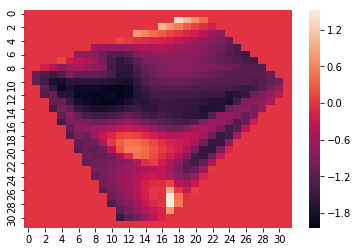

In [12]:
print(image_tensor.shape)
# np.save('test_image.npy', image_tensor)
sns.heatmap(image_tensor[0,0,:,:].squeeze())

In [36]:
trainlabeldir = './traindata/labels/'
if not os.path.exists(trainlabeldir):
    os.makedirs(trainlabeldir)

# loop through each data file and get grid
for idx,datafile in enumerate(datafiles):
    filename = path_leaf(datafile)
    labelfilename = os.path.join(trainlabeldir, filename)

    # load data
    data = np.load(datafile, encoding='bytes')
    print(data.keys())
    
    # load xyz data for this particular dataset
    seeg_contacts = data['seeg_contacts']
    seiztimes = data['seiztimes']
    timepoints = data['timepoints']

    y = np.zeros((timepoints.shape[0],1))

    for jdx, i in enumerate(seiztimes):
        # Determine the starting window point of the seiztimes
        start_position = np.where(timepoints[:,1]>i[0])[0][0]
        
        # Determine the starting window point of the seiztimes
        end_position = np.where(timepoints[:,1]>i[1])[0][0]

        y[start_position:end_position] = 1

#         print('\n\nseizure points',i)
#         print('start window',timepoints[start_position])
#         print('end window',timepoints[end_position])

    print(idx)
    # save image and meta data
    np.save(labelfilename, y)
#     plt.figure()
#     plt.plot(y,'k*')
#     break

['power', 'timepoints', 'seiztimes', 'locs', 'seeg_contacts', 'x0ez']
0
['power', 'timepoints', 'seiztimes', 'locs', 'seeg_contacts', 'x0ez']
1
['power', 'timepoints', 'seiztimes', 'locs', 'seeg_contacts', 'x0ez']
2
['power', 'timepoints', 'seiztimes', 'locs', 'seeg_contacts', 'x0ez']
3
['power', 'timepoints', 'seiztimes', 'locs', 'seeg_contacts', 'x0ez']
4
['power', 'timepoints', 'seiztimes', 'locs', 'seeg_contacts', 'x0ez']
5
['power', 'timepoints', 'seiztimes', 'locs', 'seeg_contacts', 'x0ez']
6
['power', 'timepoints', 'seiztimes', 'locs', 'seeg_contacts', 'x0ez']
7
['power', 'timepoints', 'seiztimes', 'locs', 'seeg_contacts', 'x0ez']
8
['power', 'timepoints', 'seiztimes', 'locs', 'seeg_contacts', 'x0ez']
9
['power', 'timepoints', 'seiztimes', 'locs', 'seeg_contacts', 'x0ez']
10
['power', 'timepoints', 'seiztimes', 'locs', 'seeg_contacts', 'x0ez']
11
['power', 'timepoints', 'seiztimes', 'locs', 'seeg_contacts', 'x0ez']
12
['power', 'timepoints', 'seiztimes', 'locs', 'seeg_contacts',

# 3. Concatenate All Images and Labels

In [51]:
trainimagedir = './traindata/images/'
metadir = './traindata/meta/'
if not os.path.exists(trainimagedir):
    os.makedirs(trainimagedir)
if not os.path.exists(metadir):
    os.makedirs(metadir)
trainlabeldir = './traindata/labels/'
if not os.path.exists(trainlabeldir):
    os.makedirs(trainlabeldir)

images = []
# loop through each data file and get grid
for idx,datafile in enumerate(datafiles):
    filename = path_leaf(datafile) + '.npy'
    metafile = path_leaf(datafile)
    imagefile = os.path.join(trainimagedir, filename)
    metafile = os.path.join(metadir, metafile)
    labelsfile = os.path.join(trainlabeldir, filename)
    
    metadata = np.load(metafile)
    metadata = metadata['metadata'].item()
#     print(metadata.keys())
    image = np.load(imagefile)
    label = np.load(labelsfile)
    
    if idx == 0:
        images = image
        ylabels = label
    else:
        images = np.concatenate((images, image), axis=0)
        ylabels = np.concatenate((ylabels, label), axis=0)
        
#     print(imagefile)
#     print(labelsfile)
#     print(image.shape)
#     print(label.shape)
    
#     break
print(images.shape)
print(ylabels.shape)

dict_keys(['x0ez', 'seeg_contacts', 'new_locs'])
dict_keys(['x0ez', 'seeg_contacts', 'new_locs'])
dict_keys(['x0ez', 'seeg_contacts', 'new_locs'])
dict_keys(['x0ez', 'seeg_contacts', 'new_locs'])
dict_keys(['x0ez', 'seeg_contacts', 'new_locs'])
dict_keys(['x0ez', 'seeg_contacts', 'new_locs'])
dict_keys(['x0ez', 'seeg_contacts', 'new_locs'])
dict_keys(['x0ez', 'seeg_contacts', 'new_locs'])
dict_keys(['x0ez', 'seeg_contacts', 'new_locs'])
dict_keys(['x0ez', 'seeg_contacts', 'new_locs'])
dict_keys(['x0ez', 'seeg_contacts', 'new_locs'])
dict_keys(['x0ez', 'seeg_contacts', 'new_locs'])
dict_keys(['x0ez', 'seeg_contacts', 'new_locs'])
dict_keys(['x0ez', 'seeg_contacts', 'new_locs'])
dict_keys(['x0ez', 'seeg_contacts', 'new_locs'])
dict_keys(['x0ez', 'seeg_contacts', 'new_locs'])
dict_keys(['x0ez', 'seeg_contacts', 'new_locs'])
dict_keys(['x0ez', 'seeg_contacts', 'new_locs'])
dict_keys(['x0ez', 'seeg_contacts', 'new_locs'])
dict_keys(['x0ez', 'seeg_contacts', 'new_locs'])
dict_keys(['x0ez', '

In [54]:
np.save('/Volumes/ADAM LI/traindata/finaltrain/trainimages.npy', images)
np.save('/Volumes/ADAM LI/traindata/finaltrain/trainlabels.npy', ylabels)